In [1]:
!pip install seaborn

# Import Section

This cell initializes a Spark session, sets up database connection properties, and loads data from the `bin_state_notification` table. It then selects only the necessary columns (`litter_bin_uuid`, `point_in_time`, `notification_type`) and converts the `point_in_time` column to a timestamp format.

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_timestamp, col, lead, when, unix_timestamp, hour, dayofweek, lag, avg, \
    stddev
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns


# Loading and preparing the data

As a first step we initialize the spark context and fetch all the notifications from the database. From this data we only need the `litter_bin_uuid`, `point_in_time` and the `notification_type`. The `point_in_time` we have to convert to a timestamp so that we then can order all the data by time and responding uuid of the bin.

In [3]:
spark = SparkSession.builder \
    .appName("SmartLitter") \
    .getOrCreate()

jdbc_url = "jdbc:postgresql://db:5432/litter_db"
connection_properties = {
    "user": "root",
    "password": "pwd123",
    "driver": "org.postgresql.Driver",
    "stringtype": "unspecified"
}

bin_state_df = spark.read.jdbc(
    url=jdbc_url,
    table='public.bin_state_notification',
    properties=connection_properties
).select('litter_bin_uuid', 'point_in_time', 'notification_type') \
    .withColumn('point_in_time', to_timestamp('point_in_time')) \
    .orderBy('litter_bin_uuid', 'point_in_time')

# Feature Engineering

Now that we loaded and prepared our data we can start with the feature engineering. For our features we want the day and hour the bin has been emptied. In addition, we want some metrics, more specific the time span until a bin has been full again, the average time until a bin is full and the standard deviation so we have some differentiation between the bins. Since our data is categorical (each bin with its own uuid), we need to one hot encode it. This way we can convert the bin uuid into a numerical value. If we would not do this the model would be trained over all bins, but we want to treat each bin on their own since each bin has its own history.



In [4]:
feature_cols = ['hour_of_day', 'day_of_week', 'prev_time_to_full_hours', 'avg_time_to_full_hours', 'stddev_time_to_full_hours', 'bin_vector']

## Create features on the data
First for each event we need to find the next emptied and full event and then we flag them. If then for example multiple full event are in between they receive the flag 0. By this flag then we can calculate the next time when the bin is full or emptied.

In [5]:
window_spec = Window.partitionBy('litter_bin_uuid').orderBy('point_in_time')

bin_state_df = bin_state_df.withColumn('is_emptied', when(col('notification_type') == 'emptied', 1).otherwise(0))
bin_state_df = bin_state_df.withColumn('is_full', when(col('notification_type') == 'full', 1).otherwise(0))

bin_state_df = bin_state_df.withColumn('next_full_time', lead(
    when(col('is_full') == 1, col('point_in_time')), 1
).over(window_spec))
bin_state_df = bin_state_df.withColumn('next_emptied_time', lead(
    when(col('is_emptied') == 1, col('point_in_time')), 1
).over(window_spec))

With that information now we can calculate the time until the bin has been full again for all the bins over all time. In addition, we filter out all events that have no `full` event after an emptied event occurred.

In [6]:
emptied_events_df = bin_state_df.filter(col('is_emptied') == 1)
emptied_events_df = emptied_events_df.withColumn('time_to_full_hours',
        (unix_timestamp('next_full_time') - unix_timestamp('point_in_time')) / 3600
)
emptied_events_df = emptied_events_df.filter(col('next_full_time').isNotNull())

We have now prepared all of our data to apply the features to it. We extract the hour and the day the bin has been emptied. Since we now have the time until a bin is full we can compute all the previous time until a bin has been full with the offset value. We want this because it better represents the history of a bin until it is full again. Then we compute the statistics for each bin, giving us the average and standard deviation until a bin is full. In the last step if no previous time until a bin is full was not able to calculate we just replace the null value with the average.

In [7]:
emptied_events_df = emptied_events_df.withColumn('hour_of_day', hour('point_in_time'))
emptied_events_df = emptied_events_df.withColumn('day_of_week', dayofweek('point_in_time'))

emptied_events_df = emptied_events_df.withColumn('prev_time_to_full_hours', lag('time_to_full_hours', 1).over(window_spec))

avg_time_to_full = emptied_events_df.groupBy('litter_bin_uuid').agg(
    avg('time_to_full_hours').alias('avg_time_to_full_hours'),
    stddev('time_to_full_hours').alias('stddev_time_to_full_hours')
)

emptied_events_df = emptied_events_df.join(avg_time_to_full, on='litter_bin_uuid', how='left')

final_df = emptied_events_df.withColumn('prev_time_to_full_hours',
    when(col('prev_time_to_full_hours').isNull(),
        col('avg_time_to_full_hours')).otherwise(col('prev_time_to_full_hours'))
)

# Training the model

Now that we have our prepared data we can start training it. In a first step we split the data into a train and test set with an 80% to 20% distribution.

In [8]:
train_df, test_df = final_df.randomSplit([0.8, 0.2], seed=42)

First we convert the litter bin uuid to a numerical index with a string indexer. With this we can then one hot encode it so we get the vector distances for each bin. Then we assemble all of our into vectors. This combined then with the one hot encoded bin uuids gives us all needed features.

In [9]:
indexer = StringIndexer(inputCol='litter_bin_uuid', outputCol='bin_index')
encoder = OneHotEncoder(inputCols=['bin_index'], outputCols=['bin_vector'])
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')


For our model we are choosing a random forest algorithm. The reason for this beeing is that the relationship between our features is non linear.

In [10]:
rf = RandomForestRegressor(featuresCol='features', labelCol='time_to_full_hours', numTrees=500)

Now we can assemble our ml pipeline that applies all these steps.

In [11]:
pipeline = Pipeline(stages=[indexer, encoder, assembler, rf])
regression_model = pipeline.fit(train_df)
regression_model.save("./models/RegressionModel_3")

# Model Evaluation

Now that we trained our model we want to evaluate the effectiveness of it. Remember, we generated our own test data so the precision and accuracy of the model is heavily influenced by this. Because of that we cannot be 100% sure if the model behaves the same on actual real world data.

With our test data we can make the predictions. Then with the `root mean squared error` and the `mean absolute error` we can have a first idea how our model performs. The lower both values are the better and in addition the closer together they are the better. 

In [12]:
predictions = regression_model.transform(test_df)

evaluator = RegressionEvaluator(labelCol='time_to_full_hours', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

mae_evaluator = RegressionEvaluator(labelCol='time_to_full_hours', predictionCol='prediction', metricName='mae')
mae = mae_evaluator.evaluate(predictions)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

Root Mean Squared Error (RMSE): 54.58
Mean Absolute Error (MAE): 35.22


As we can observer the error rates are not bad but also not good. There is definitely room for improvement on the model that would need to be done with a lot of hyperparameter tuning and adding more features to it.

In addition, we can also evaluate how the model performs on a prediction horizon, i.e. a time delta. We can then compute the `roc auc` score. It gives us a metric to indicate how well the model distinguishes between two classes, i.e. in our case if the bin is full or not. The higher the score the better. With this data we then can also plot a confusion matrix.

ROC AUC Score: 0.76


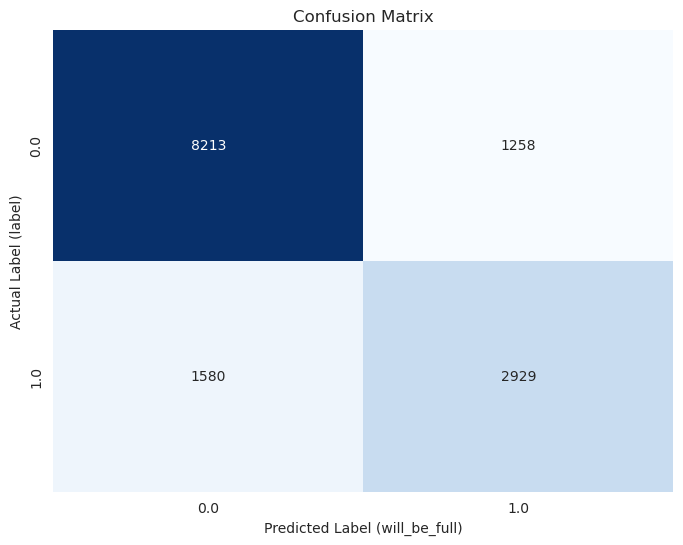

In [13]:
prediction_horizon_hours = 10

test_predictions = regression_model.transform(test_df)

test_predictions = test_predictions.withColumn('will_be_full', when(
    col('prediction') <= prediction_horizon_hours, 1.0
).otherwise(0.0))

test_predictions = test_predictions.withColumn('label', when(
    col('time_to_full_hours') <= prediction_horizon_hours, 1.0
).otherwise(0.0))

binary_evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='will_be_full', metricName='areaUnderROC')

roc_auc = binary_evaluator.evaluate(test_predictions)
print(f"ROC AUC Score: {roc_auc:.2f}")

confusion_matrix_df = test_predictions.groupBy('label', 'will_be_full').count()
confusion_matrix_pivot = confusion_matrix_df.groupBy("label").pivot("will_be_full").sum("count")

confusion_matrix_pd = confusion_matrix_df.toPandas()
confusion_matrix_pivot_pd = confusion_matrix_pivot.toPandas()

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_pivot_pd.set_index('label'), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label (will_be_full)')
plt.ylabel('Actual Label (label)')
plt.show()